This notebook explains how to use the utilities provided by `lucid.scratch.rl_util` with the models from the paper [Understanding RL vision](https://distill.pub/2020/understanding-rl-vision).

# Setup

In [1]:
# use tensorflow 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# install specific version of lucid
!pip install git+git://github.com/tensorflow/lucid.git@16a03dee8f99af4cdd89d6b7c1cc913817174c83

  Cloning git://github.com/tensorflow/lucid.git (to revision 16a03dee8f99af4cdd89d6b7c1cc913817174c83) to /tmp/pip-req-build-02w3ic5f
  Running command git clone -q git://github.com/tensorflow/lucid.git /tmp/pip-req-build-02w3ic5f
  Created wheel for lucid: filename=lucid-0.3.9-cp36-none-any.whl size=159191 sha256=ce3c73a40525abeb8db2a694beab6b743f5520a9ea0d02bf0cb49f008ea87249
  Stored in directory: /tmp/pip-ephem-wheel-cache-hn4kltt2/wheels/39/c8/8e/6b03eb4e2617bf64fb67125838d2dad660486ceb18bbe46141
Successfully built lucid
  Found existing installation: lucid 0.3.8
    Uninstalling lucid-0.3.8:
      Successfully uninstalled lucid-0.3.8


In [3]:
def longest_common_prefix(l):
    l = set([s[: min(map(len, l))] for s in l])
    while len(l) > 1:
        l = set([s[:-1] for s in l])
    return list(l)[0]


def longest_common_suffix(l):
    l = set([s[-min(map(len, l)) :] for s in l])
    while len(l) > 1:
        l = set([s[1:] for s in l])
    return list(l)[0]


# small utility for abbreviating a list of names
def get_abbreviator(names):
    if len(names) <= 1:
        return slice(None, None)
    prefix = longest_common_prefix(names)
    prefix = prefix.rsplit("/", 1)[0] + "/" if "/" in prefix else ""
    suffix = longest_common_suffix(names)
    suffix = "/" + suffix.split("/", 1)[-1] if "/" in suffix else ""
    return slice(len(prefix), None if len(suffix) == 0 else -len(suffix))

# Import utilities and load data

First let's import the utilities.


In [4]:
import numpy as np
import tensorflow as tf
from collections import OrderedDict
from lucid.modelzoo.vision_base import Model
from lucid.scratch.rl_util import *
# get_abbreviator defined during setup

# hide tensorflow deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


Here's a list of all the utilities we imported from `lucid.scratch.rl_util`.

In [5]:
print(", ".join(all_()))

np, tf, Model, ChannelReducer, param, objectives, render, transform, show, save, _image_url, _display_html, lucid_svelte, load_joblib, save_joblib, zoom_to, get_var, get_shape, concatenate_horizontally, hue_to_rgb, channels_to_rgb, conv2d, norm_filter, brightness_to_opacity, gradient_override_map, maxpool_override, get_acts, get_grad_or_attr, get_attr, get_grad, get_paths, get_multi_path_attr, argmax_nd, LayerNMF, rescale_opacity, all_, reload


Now let's load the data for the model we want to analyze. The available models are indexed [here](https://openaipublic.blob.core.windows.net/rl-clarity/attribution/models/index.html). In this example, we use the original CoinRun model, whose `<relpath>/<name>` is `coinrun`.

In [6]:
def load_data(relpath_name):
    basepath = "https://openaipublic.blob.core.windows.net/rl-clarity/attribution/models/"
    if "/" in relpath_name:
        relpath, name = relpath_name.rsplit("/")
        relpath += "/"
    else:
        relpath = ""
        name = relpath_name
    dirpath = f"{basepath}{relpath}rl-clarity/"

    result = {}
    result["model"] = Model.load(f"{dirpath}{name}.model.pb")
    result.update(load_joblib(f"{dirpath}{name}.metadata.jd"))
    result.update(load_joblib(f"{dirpath}{name}.observations.jd"))
    result["trajectories"] = load_joblib(f"{dirpath}{name}.trajectories.jd")

    result["observations"] = result["observations"] / np.float(255)
    result["trajectories"]["observations"] = result["trajectories"]["observations"] / np.float(255)

    layer_names = [
        node.name
        for node in result["model"].graph_def.node
        if len(get_shape(result["model"], node.name)) >= 4 and node.op.lower() == "relu"
    ]
    abbreviator = get_abbreviator(layer_names)
    result["layer_names"] = OrderedDict(
        [(name[abbreviator], name) for name in layer_names]
    )

    return result


data = load_data("coinrun")

Let's add all of the data we've loaded as local variables, printing their names.

In [7]:
locals().update(data)
print(", ".join(data.keys()))

model, policy_logits_name, value_function_name, env_name, gae_gamma, gae_lambda, action_combos, observations, trajectories, layer_names


Let's explain each of these variables:

- `model: lucid.modelzoo.vision_base.Model` &ndash; Lucid model
- `policy_logits_name: str` &ndash; name of the policy head tensor in the model
- `value_function_name: str` &ndash; name of the value head tensor in the model
- `env_name: str` &ndash; name of the environment
- `gae_gamma: float` &ndash; generalized advantage estimation hyperparameter $\gamma$ used to train the model
- `gae_lambda: float` &ndash; generalized advantage estimation hyperparameter $\lambda$ used to train the model
- `action_combos: List[Tuple[str]]` &ndash; which combination of keys each integer action corresponds to
- `observations: np.ndarray` &ndash; batch &times; height &times; width &times; channels float array of observations sampled infrequently from the agent playing the game, intended to be used for NMF
- `trajectories: Dict[str, np.ndarray]` &ndash; dictionary from contiguous trajectories of the agent playing the game with the following keys:
    - `observations` &ndash; trajectories &times; timesteps &times; height &times; width &times; channels float array of observations
    - `actions` &ndash; trajectories &times; timesteps array of integer actions
    - `rewards` &ndash; trajectories &times; timesteps array of float rewards
    - `firsts` &ndash; trajectories &times; timesteps array of booleans specifying whether the timestep was the first in the episode
- `layer_names: OrderedDict[str, str]` &ndash; mapping from the abbreviated names to the full names of the activation tensors of the convolutional layers in the model

Let's print the abbreviated layer names that were found.

In [8]:
print(", ".join(layer_names.keys()))

1a, 2a, 2b, 3a, 4a


The `zoom_to` and `show` utilities are useful for displaying observations and visualizations.


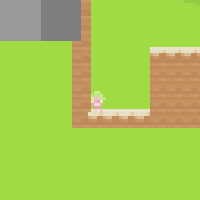
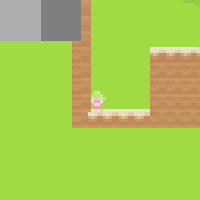
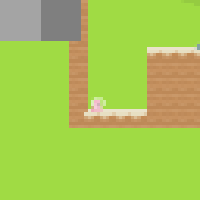
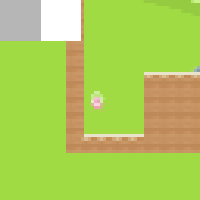
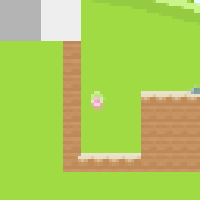
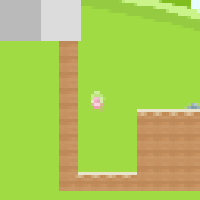
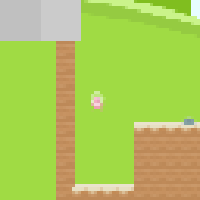
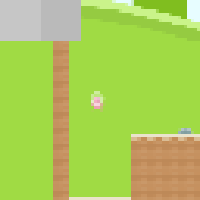

In [9]:
show(zoom_to(trajectories["observations"][0, :8], 200))

# Dimensionality reduction and feature visualization

The `LayerNMF` utility can be used to apply NMF dimensionality reduction to obtain directions in activation space, and then to use feature visualization (either gradient-based or dataset example-based) to visualize those directions.

Passing `attr_layer_name=value_function_name` causes NMF to be applied to value function attributions. If we did not pass this, NMF would instead be applied to activations.

We use the infrequently-sampled `observations` rather than observations from `trajectories` in order to cover a broader distribution of observations.

In [10]:
# can take a couple of minutes
# for the paper, we use observations[:], but this requires more memory
nmf = LayerNMF(model, layer_names['2b'], observations[:1024], features=8, attr_layer_name=value_function_name)

The directions in activation space obtained are given by the `channel_dirs` property.

In [11]:
nmf.channel_dirs.shape

(8, 32)

We can now visualize these directions in activation space in various ways.

We can apply gradient-based feature visualization using the `vis_traditional` method.

512 273.1749



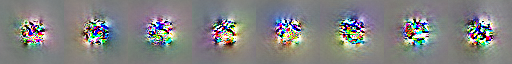


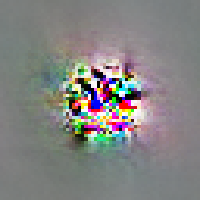
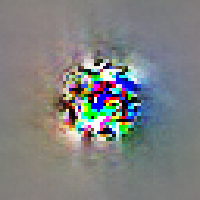
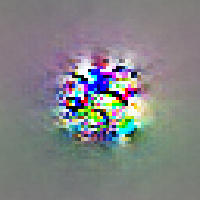
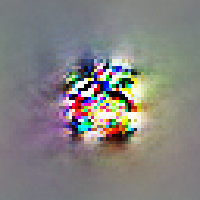
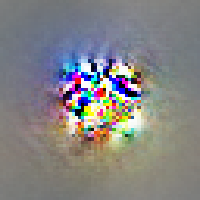
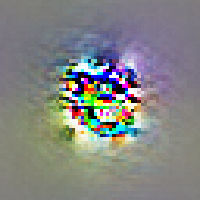
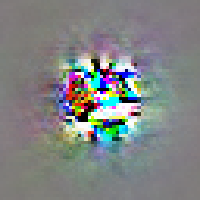
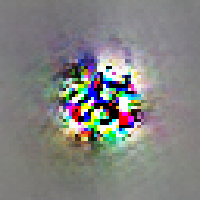

In [12]:
show(zoom_to(nmf.vis_traditional(), 200))

We can apply dataset example-based feature visualization using the `vis_dataset_thumbnail` method. `num_mult` gives the height and width of the grid of patches, and `expand_mult` is a multiplier on the size of each patch.

The strength of the activation for the image from which the patch was taken is given in the alpha (opacity) channel of the visualization (scaled to be at most 1).


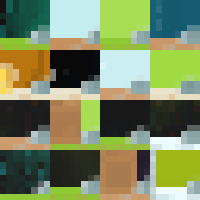
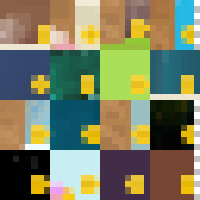
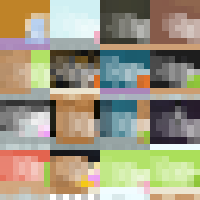
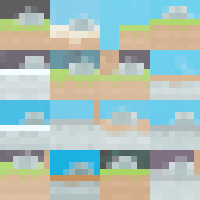
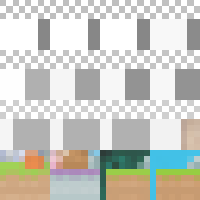
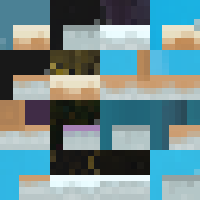
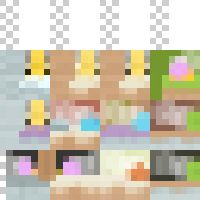
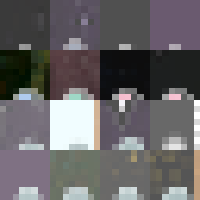

In [13]:
show([zoom_to(nmf.vis_dataset_thumbnail(i, num_mult=4, expand_mult=4)[0], 200) for i in range(nmf.features)])

We can apply spatially-aware dataset example-based feature visualization using the `vis_dataset` method. `subdiv_mult` gives the height and width of the grid of patches per activation, and `expand_mult` is again a multiplier on the size of each patch.

Activation strength is again given by opacity, so most of the top and left of the image is transparent since coins do not usually appear in those parts of observations.


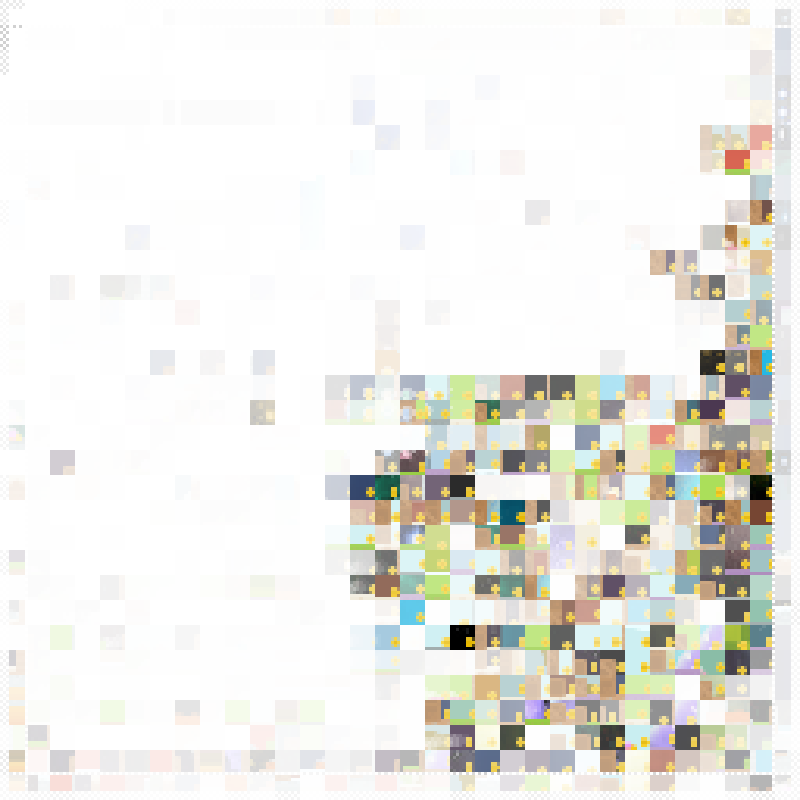

In [14]:
show(zoom_to(nmf.vis_dataset(1, subdiv_mult=1, expand_mult=4)[0], 800))

# Attribution

The `get_acts` utility can be used to get activations. We can use this to get the model's value function for some observations.


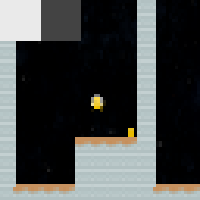
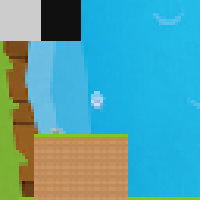
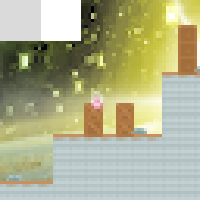
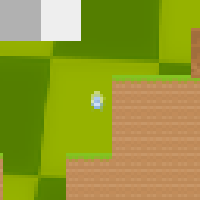
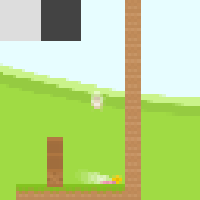
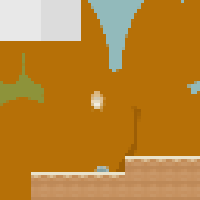
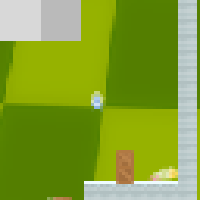
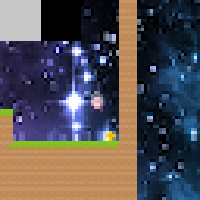

In [15]:
value_functions = get_acts(model, value_function_name, observations[:8])
show(zoom_to(observations[:8], 200), labels=[f"{v:.3f}" for v in value_functions])

The `get_attr` utility can be used to get attributions using the integrated gradients method. The number of steps used for the numerical integration is specified by `integrate_steps`. Here we apply this to some observations from a trajectory.

We pass `value_function_name` in order to get value function attributions. If we passed the name of a tensor with more than one element (such as `policy_logits_name`), then we could use `score_fn` to specify how to reduce that tensor to a single element (note that `score_fn` should not reduce the batch dimension).

In [16]:
traj = trajectories['observations'][0][76:84]
attr = get_attr(model, value_function_name, layer_names['2b'], traj, integrate_steps=10)
attr.shape

(8, 32, 32, 32)

We can apply dimensionality reduction to these attributions using the `LayerNMF` object we generated earlier.

In [17]:
attr_reduced = nmf.transform(np.maximum(attr, 0)) - nmf.transform(np.maximum(-attr, 0))  # transform the positive and negative parts separately
nmf_norms = nmf.channel_dirs.sum(-1)
attr_reduced *= nmf_norms[None, None, None]  # multiply by the norms of the NMF directions, since the magnitudes of the NMF directions are not relevant
attr_reduced /= np.median(attr_reduced.max(axis=(-3, -2, -1)))  # globally normalize by the median max value to make the visualization balanced (a bit of a hack)
attr_reduced.shape

(8, 32, 32, 8)

Here are the observations along with the positive and negative parts of the attributions, which we visualize by assigning a different color to each of the post-NMF channels.

observation



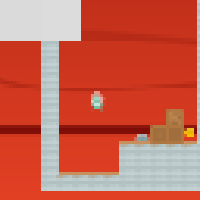
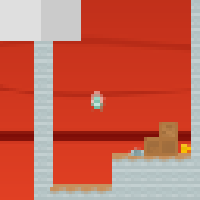
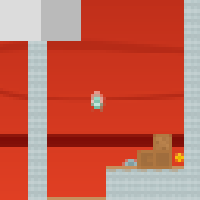
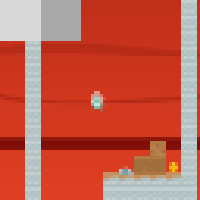
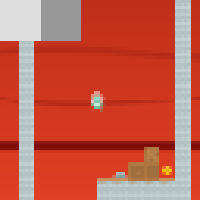
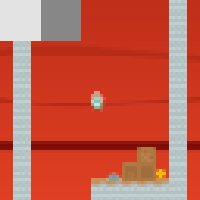
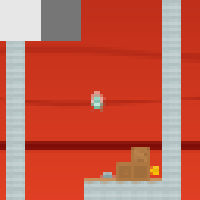
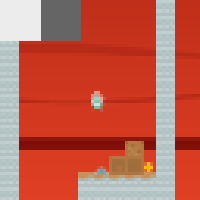

positive attribution



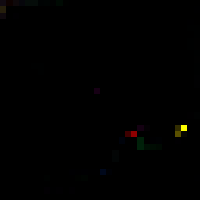
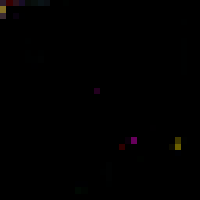
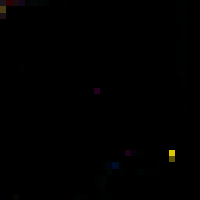
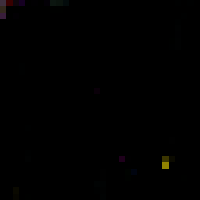
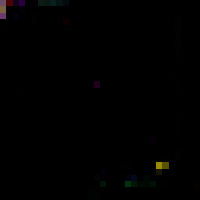
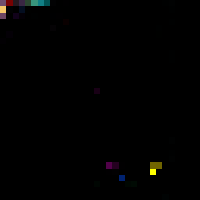
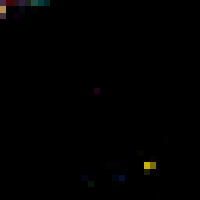
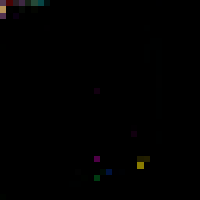

negative attribution



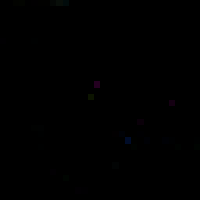
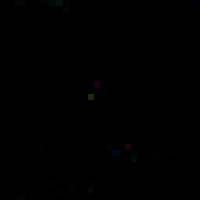
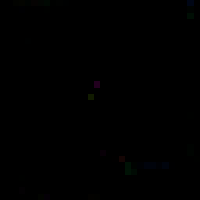
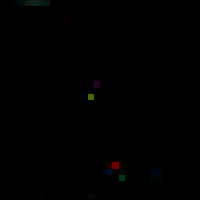
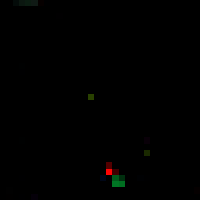
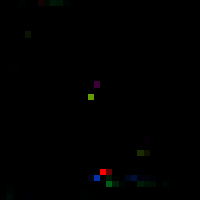
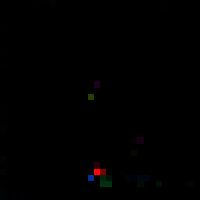
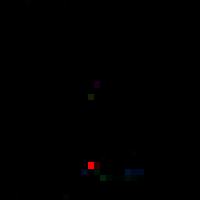

In [18]:
attr_pos = np.maximum(attr_reduced, 0)
attr_neg = np.maximum(-attr_reduced, 0)
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(attr_pos, 200))
print("negative attribution")
show(zoom_to(attr_neg, 200))

We can use the `conv2d` and `norm_filter` utilities to smooth out attribution over nearby spatial positions, so that the amount of visual space taken up can be used to judge attribution strength.

observation



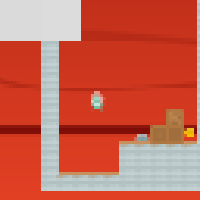
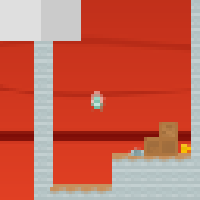
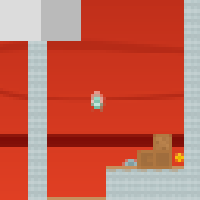
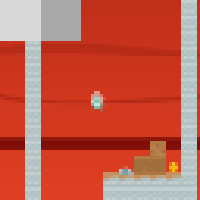
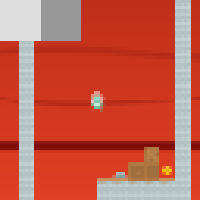
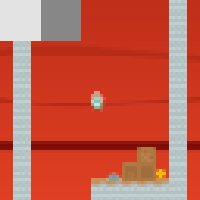
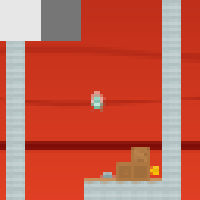
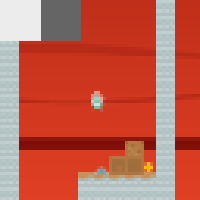

positive attribution



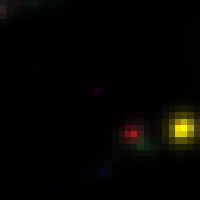
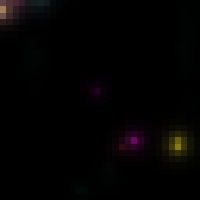
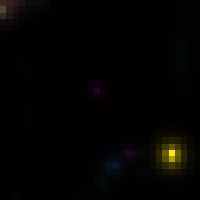
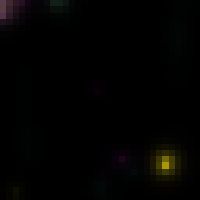
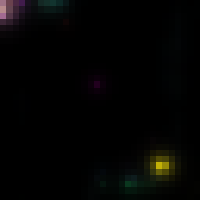
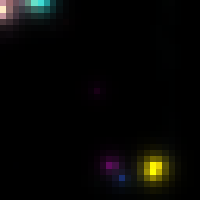
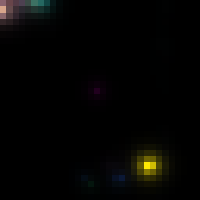
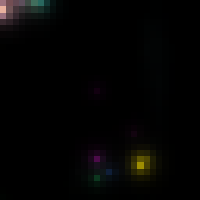

negative attribution



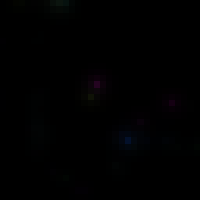
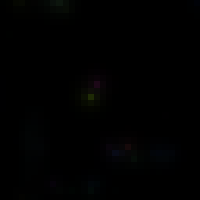
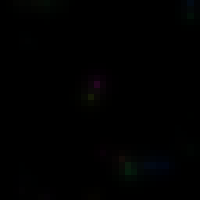
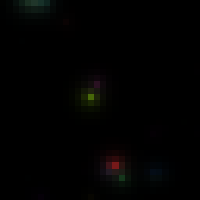
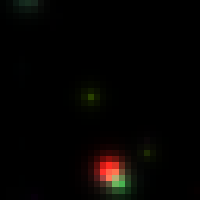
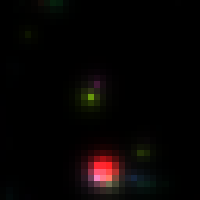
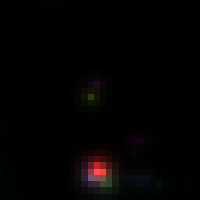
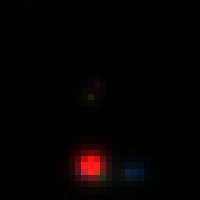

In [19]:
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(conv2d(attr_pos, filter_=norm_filter(15)), 200))
print("negative attribution")
show(zoom_to(conv2d(attr_neg, filter_=norm_filter(15)), 200))

# Model editing

To edit the model in-place, we can use Lucid's `ParameterEditor`.

In [20]:
from copy import deepcopy
from lucid.scratch.parameter_editor import ParameterEditor

edited_model = deepcopy(model)
editor = ParameterEditor(edited_model.graph_def)

To make the model blind to saw obstacles, we can use the first NMF direction. We edit the convolutional kernel of the next layer to make it project out the NMF direction from activations before applying the original kernel.

In [21]:
kernel_name = layer_names["3a"].replace("Relu", "conv2d/kernel")  # name of tensor of convolutional kernel of next layer
kernel = editor[kernel_name]
saw_dir = nmf.channel_dirs[0][None, None, :, None]  # first NMF direction, corresponding to saw obstacle
saw_dir /= np.linalg.norm(saw_dir)
# the kernel is left-multiplied by the activations from the previous layer, so we left-multiply the kernel by the projection matrix
kernel = kernel - saw_dir * (saw_dir * kernel).sum(axis=-2, keepdims=True)  # equivalently: kernel - saw_dir @ saw_dir.transpose((0, 1, 3, 2)) @ kernel
editor[kernel_name] = kernel
# note: this is not quite the same as the edit made for the paper, since we only used 1024 observations for the NMF calculation here

We can use the `get_var` utility to verify that the kernel has been updated.

In [22]:
print(np.linalg.norm(get_var(model, kernel_name)))
print(np.linalg.norm(get_var(edited_model, kernel_name)))

31.603941
30.58285


If we now repeat the attribution visualization from above with the edited model, we see that the red saw obstacle channel has disappeared, while the yellow coin channel remains present.

observation



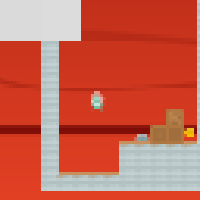
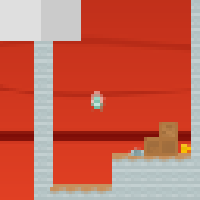
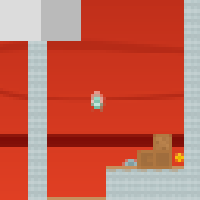
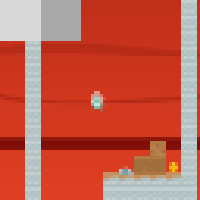
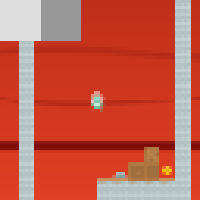
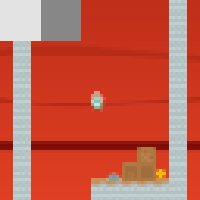
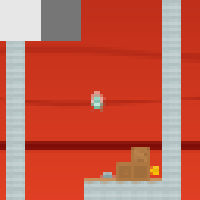
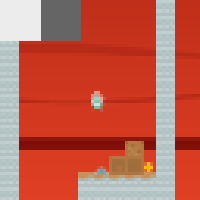

positive attribution



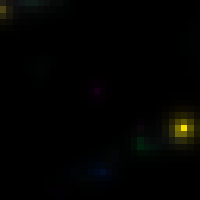
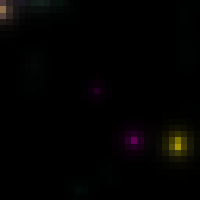
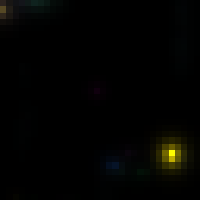
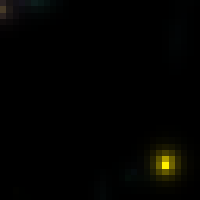
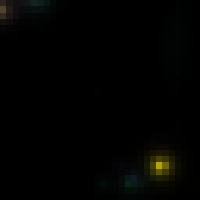
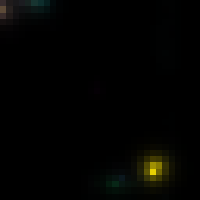
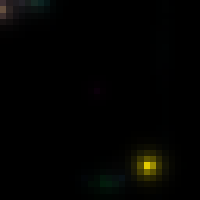
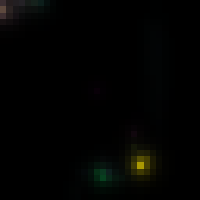

negative attribution



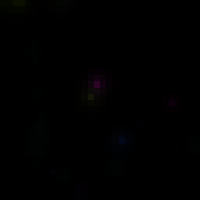
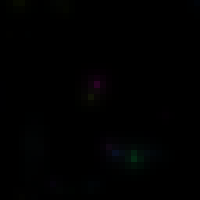
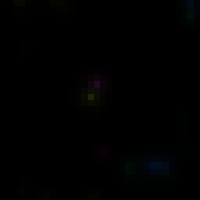
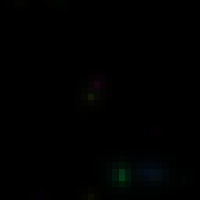
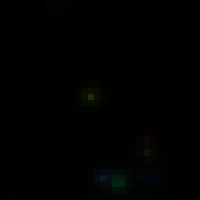
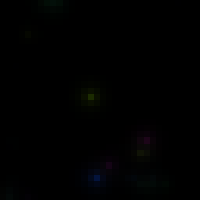
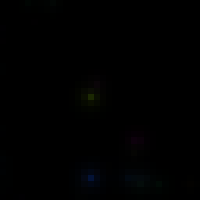
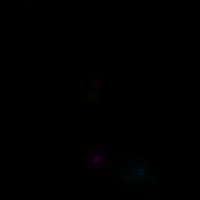

In [23]:
traj = trajectories['observations'][0][76:84]
attr = get_attr(edited_model, value_function_name, layer_names['2b'], traj, integrate_steps=10)
attr_reduced = nmf.transform(np.maximum(attr, 0)) - nmf.transform(np.maximum(-attr, 0))
nmf_norms = nmf.channel_dirs.sum(-1)
attr_reduced *= nmf_norms[None, None, None]
attr_reduced /= np.median(attr_reduced.max(axis=(-3, -2, -1)))
attr_pos = np.maximum(attr_reduced, 0)
attr_neg = np.maximum(-attr_reduced, 0)
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(conv2d(attr_pos, filter_=norm_filter(15)), 200))
print("negative attribution")
show(zoom_to(conv2d(attr_neg, filter_=norm_filter(15)), 200))